In [1]:
# Шаардлагатай сангуудыг импортлох
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np
import time 

# Тохиргоо
latent_dim = 64  # Шахалтын хэмжээ
batch_size = 128
learning_rate_ae = 4e-4
learning_rate_cls = 4e-4
epochs_ae = 10
epochs_cls = 30

# GPU эсвэл CPU ашиглах эсэхийг шалгах
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Ашиглаж буй төхөөрөмж: {device}')

Ашиглаж буй төхөөрөмж: cuda


In [2]:
transform = transforms.ToTensor()
# MNIST датасетыг татах
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

# Даталоудерыг бий болгох
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

print('Датасет бэлэн боллоо!')

Датасет бэлэн боллоо!


In [3]:
# Автокодлогчийн загвар
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Кодлогч
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),   #(1, 28, 28)->(16, 14, 14)
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),  #(16, 14, 14)->(32, 7, 7)
            nn.ReLU(),
            nn.Conv2d(32, 64, 7),                       #(32, 7, 7)->(64, 1, 1)
        )
        # Декодлогч
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Tanh()  # [-1, 1] завсарт     оруулах
        )
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

class AEClassifier(nn.Module):
    def __init__(self, ae_encoder, latent_dim, num_classes=10):
        super(AEClassifier, self).__init__()
        self.encoder = ae_encoder
        for param in self.encoder.parameters(): 
            param.requires_grad = False # Freeze энкодлогч 
            
        self.classifier = nn.Sequential(
            nn.Flatten(), 
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(128, num_classes)
        )
        
    def forward(self, x):
        encoded = self.encoder(x)
        logits = self.classifier(encoded)
        return logits
    
# Загвар 1-ыг бий болгох
print('\n- - - 1. Autoencoder-ийг сургах нь - - - ')
ae_model = Autoencoder().to(device)
criterion_ae = nn.MSELoss()
optimizer_ae = optim.Adam(ae_model.parameters(), lr=learning_rate_ae)

print('Загвар бэлэн боллоо!')


- - - 1. Autoencoder-ийг сургах нь - - - 
Загвар бэлэн боллоо!


In [4]:
# Сургалтын функц
ae_loss_history = []
classifier_loss_history = []

def train_ae(model, loader, criterion, optimizer, epochs, device):
    model.train()
    print('\n- - - 1. Autoencoder-ийг сургах нь - - - ')
    for epoch in range(epochs):
        running_loss = 0.0
        for data, _ in loader:
            data = data.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, data)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        avg_loss = running_loss / len(loader)
        ae_loss_history.append(avg_loss)
        print(f'AE Epoch {epoch+1}/{epochs}, MSE Алдагдал: {avg_loss:.4f}')
        
        if (epoch + 1) % 10 == 0:
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': avg_loss
            }, f"checkpoint_epoch_{epoch+1}.pth")

            print(f"Хадгаллаа: checkpoint_epoch_{epoch+1}.pth")

# Сургалтыг эхлүүлэх
train_ae(ae_model, train_loader, criterion_ae, optimizer_ae, epochs_ae, device)


- - - 1. Autoencoder-ийг сургах нь - - - 
AE Epoch 1/10, MSE Алдагдал: 0.0424
AE Epoch 2/10, MSE Алдагдал: 0.0102
AE Epoch 3/10, MSE Алдагдал: 0.0065
AE Epoch 4/10, MSE Алдагдал: 0.0051
AE Epoch 5/10, MSE Алдагдал: 0.0044
AE Epoch 6/10, MSE Алдагдал: 0.0039
AE Epoch 7/10, MSE Алдагдал: 0.0036
AE Epoch 8/10, MSE Алдагдал: 0.0033
AE Epoch 9/10, MSE Алдагдал: 0.0032
AE Epoch 10/10, MSE Алдагдал: 0.0030
Хадгаллаа: checkpoint_epoch_10.pth


In [5]:
print('\n- - - 2. AE-д суурилсан ангилагчийг сургах нь - - -')

# AE сургагдсан тул түүний Encoder-ийг ашиглан Classifier үүсгэнэ
classifier_model = AEClassifier(ae_model.encoder, latent_dim).to(device) 
criterion_cls = nn.CrossEntropyLoss()
optimizer_cls = optim.Adam(classifier_model.parameters(), lr=learning_rate_cls)

# Сургалтын функц (Classifier)
def train_classifier(model, train_loader, criterion, optimizer, epochs, device):
    model.train()
    print("Classifier сургалт эхэллээ...")
    for epoch in range(epochs):
        total_loss = 0
        correct = 0
        total = 0
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            
            # Accuracy тооцоолох
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
        
        avg_epoch_loss = total_loss / len(train_loader)
        classifier_loss_history.append(avg_epoch_loss)

        print(f'Classifer эпоч {epoch+1}/{epochs}, CEL Алдагдал: {avg_epoch_loss:.4f}, Оновчтой байдал: {100*correct/total:.2f}%')
        
# Classifier сургалтыг эхлүүлэх
train_classifier(classifier_model, train_loader, criterion_cls, optimizer_cls, epochs_cls, device)


- - - 2. AE-д суурилсан ангилагчийг сургах нь - - -
Classifier сургалт эхэллээ...
Classifer эпоч 1/30, CEL Алдагдал: 0.7534, Оновчтой байдал: 77.00%
Classifer эпоч 2/30, CEL Алдагдал: 0.3377, Оновчтой байдал: 89.94%
Classifer эпоч 3/30, CEL Алдагдал: 0.2700, Оновчтой байдал: 92.02%
Classifer эпоч 4/30, CEL Алдагдал: 0.2324, Оновчтой байдал: 93.06%
Classifer эпоч 5/30, CEL Алдагдал: 0.2085, Оновчтой байдал: 93.85%
Classifer эпоч 6/30, CEL Алдагдал: 0.1864, Оновчтой байдал: 94.48%
Classifer эпоч 7/30, CEL Алдагдал: 0.1708, Оновчтой байдал: 94.86%
Classifer эпоч 8/30, CEL Алдагдал: 0.1618, Оновчтой байдал: 95.27%
Classifer эпоч 9/30, CEL Алдагдал: 0.1514, Оновчтой байдал: 95.51%
Classifer эпоч 10/30, CEL Алдагдал: 0.1426, Оновчтой байдал: 95.84%
Classifer эпоч 11/30, CEL Алдагдал: 0.1367, Оновчтой байдал: 95.98%
Classifer эпоч 12/30, CEL Алдагдал: 0.1330, Оновчтой байдал: 96.02%
Classifer эпоч 13/30, CEL Алдагдал: 0.1255, Оновчтой байдал: 96.26%
Classifer эпоч 14/30, CEL Алдагдал: 0.1229


- - - 3. Latent Space Cluster Map үүсгэх - - -
t-SNE тооцоолол хийж байна...


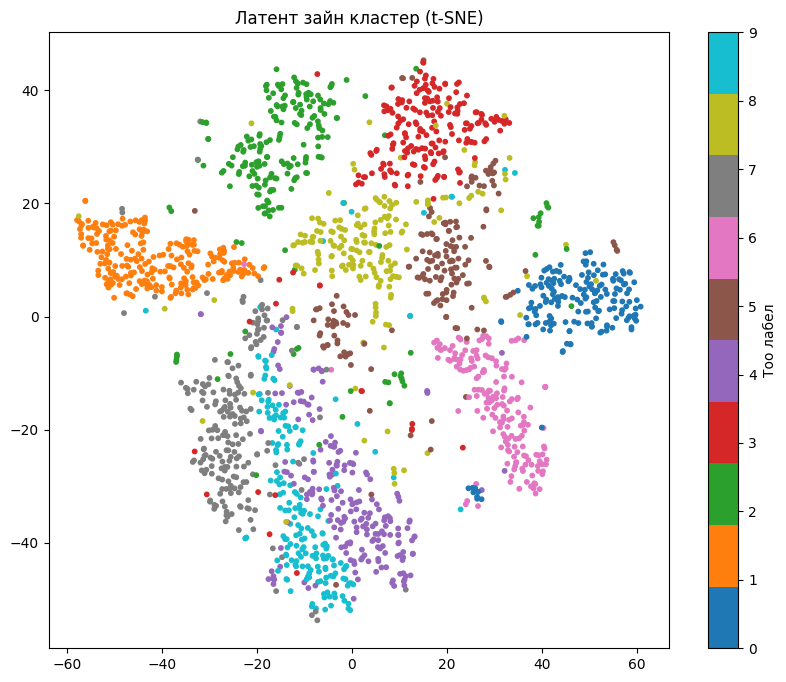

In [6]:
print('\n- - - 3. Latent Space Cluster Map үүсгэх - - -')

def plot_latent_space(encoder, test_loader, device):
    encoder.eval()
    latent_vectors = []
    labels = []
    with torch.no_grad():
        for data, target in test_loader:
            data = data.to(device)
            encoded = encoder(data).cpu().numpy()
            encoded = encoded.reshape(encoded.shape[0], -1) 
            latent_vectors.append(encoded)
            labels.append(target.numpy())

    latent_vectors = np.concatenate(latent_vectors, axis=0)
    labels = np.concatenate(labels, axis=0)

    sample_size = min(2000, len(latent_vectors))
    print("t-SNE тооцоолол хийж байна...")
    tsne = TSNE(n_components=2, random_state=42)
    latent_2d = tsne.fit_transform(latent_vectors[:sample_size])

    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=labels[:sample_size], cmap='tab10', s=10)
    plt.colorbar(scatter, label='Тоо лабел')
    plt.title('Латент зайн кластер (t-SNE)')
    plt.show()

plot_latent_space(ae_model.encoder, test_loader, device)

Тестын лосс: 0.0606
Тестын оновчтой байдал: 98.10%

- - - 50 samples дээрх жишээ - - -


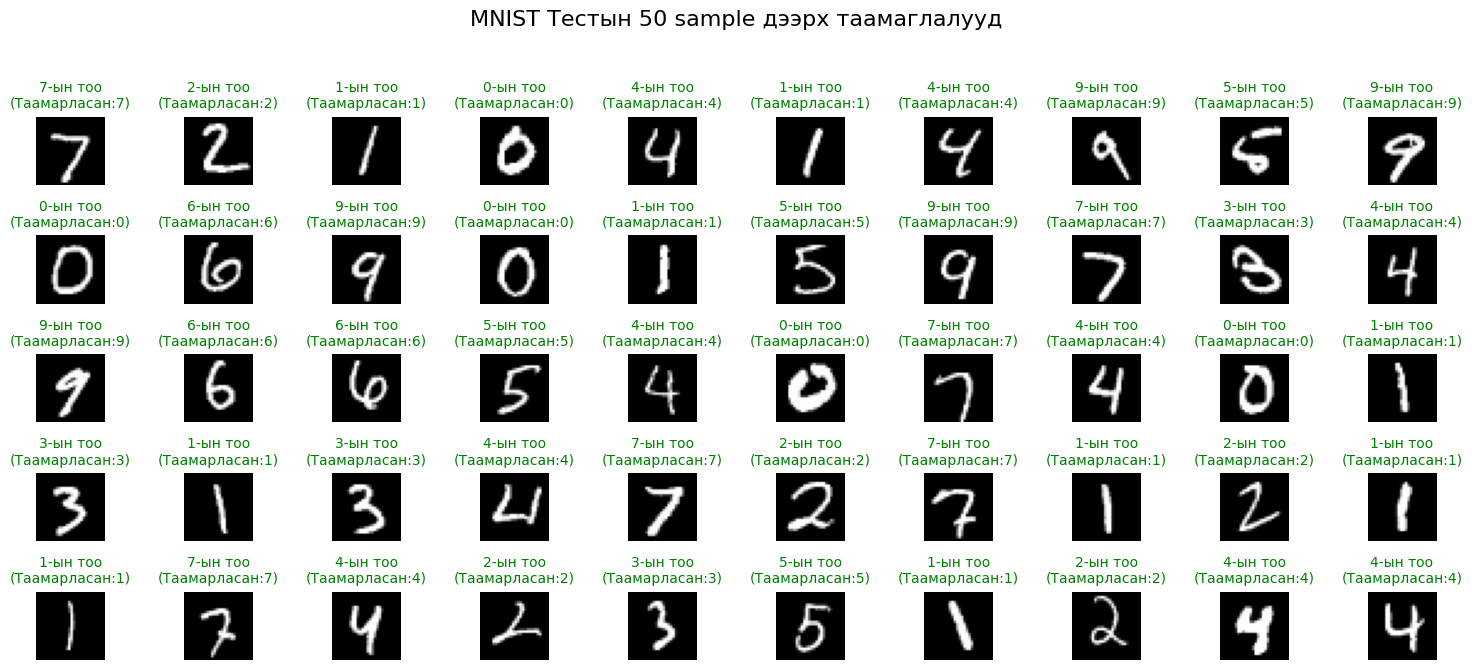

In [7]:
## --- Гаралт 2: classification үнэлгээ ---
import torchvision.datasets 
import torchvision.transforms as transforms

MNIST_MEAN = (0.1307,)
MNIST_STD = (0.3081,)
transform_test = transforms.ToTensor()

def evaluate_and_visualize(model, test_loader, criterion, device):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    all_images = []
    all_true_labels = []
    all_predicted_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            all_images.append(inputs.cpu())
            all_true_labels.append(labels.cpu())
            all_predicted_labels.append(predicted.cpu())
            
    print(f"Тестын лосс: {test_loss/len(test_loader):.4f}")
    print(f"Тестын оновчтой байдал: {100*correct/total:.2f}%")

    print("\n- - - 50 samples дээрх жишээ - - -")
    
    images = torch.cat(all_images, dim=0)[:50]
    true_labels = torch.cat(all_true_labels, dim=0)[:50]
    predicted_labels = torch.cat(all_predicted_labels, dim=0)[:50]

    images_np = images.squeeze().numpy()
    true_labels_np = true_labels.numpy()
    predicted_labels_np = predicted_labels.numpy()

    def denormalizer(tensor):
        mean, std = torch.tensor(MNIST_MEAN).view(1,1,1), torch.tensor(MNIST_STD).view(1,1,1)
        return torch.clamp(tensor * std.to(device) + mean.to(device), 0, 1)
    
    fig, axes = plt.subplots(5, 10, figsize=(15, 7))
    axes = axes.flatten()

    for i in range(50):
        img = denormalizer(images[i].to(device)).cpu().squeeze().numpy()
        ax = axes[i]
        ax.imshow(img, cmap='gray')
        
        true_label = true_labels_np[i]
        predicted_label = predicted_labels_np[i]

        title = f"{true_label}-ын тоо\n(Таамарласан:{predicted_label})"
        color = 'green' if true_label == predicted_label else 'red'
        ax.set_title(title, fontsize=10, color=color)
        ax.axis('off')

    plt.suptitle("MNIST Тестын 50 sample дээрх таамаглалууд", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

evaluate_and_visualize(classifier_model, test_loader, criterion_cls, device)

## Парамертүүдийн тоог хэмжих нь:
Олон параметртэй байх нь санах ой болон моделын ашиглалтын байдалд хүндрэл учруулна. Иймд бага парамертийн тоотой + сайн сургагдсан модел нь илүү хэрэгтэй

In [8]:
def count_parameters(model, model_name):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"--- {model_name} ---")
    print(f"Параметр: {total_params:,}")
    print(f"Сургах параметр: {trainable_params:,}")
    print(f"Сургахгүй параметр (Frozen): {total_params - trainable_params:,}\n")

count_parameters(classifier_model, "AE ангилагч")

--- AE ангилагч ---
Параметр: 114,826
Сургах параметр: 9,610
Сургахгүй параметр (Frozen): 105,216



## Inference хурд
Inference хурд буюу хэсэг batch самплыг хэдий хугацаанд процесс хийж буйг хэмжих нь:

In [10]:
def hurd(model, loader, device, num_batches=100, model_name="AE Classifier"):
    model.eval()
    
    # ЗАСВАР: MNIST зураг 28x28 хэмжээтэй тул dummy input-ийг (1, 28, 28) болгоно.
    # (32, 32) гэж өгснөөс болж shape mismatch алдаа гарч байсан.
    dummy_input = torch.randn(128, 1, 28, 28).to(device) 
    
    # Warmup: GPU/CPU-г халаах
    for _ in range(10): 
        _ = model(dummy_input) 
    
    start_time = time.time()
    with torch.no_grad():
        for i, (inputs, _) in enumerate(loader):
            if i >= num_batches: break
            # Бодит даталоадер ашиглаж байгаа тул inputs нь автоматаар (Batch, 1, 28, 28) байна
            _ = model(inputs.to(device))
            
            # GPU ашиглаж байгаа бол хугацааг зөв хэмжихийн тулд synchronize хийнэ
            if device.type == 'cuda': 
                torch.cuda.synchronize()
                
    avg_time = ((time.time() - start_time) / num_batches) * 1000
    print(f"\n--- {model_name} Speed ---")
    print(f"Inference speed per batch: {avg_time:.3f} ms")

hurd(classifier_model, test_loader, device)


--- AE Classifier Speed ---
Inference speed per batch: 5.557 ms


## Лосс дээрх график


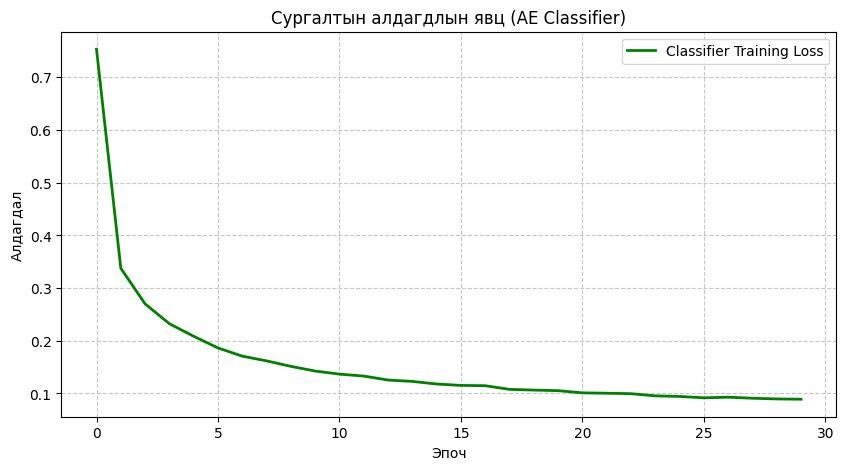

In [11]:
plt.figure(figsize=(10, 5))
plt.plot(classifier_loss_history, label='Classifier Training Loss', color='green', linewidth=2)
plt.title('Сургалтын алдагдлын явц (AE Classifier)')
plt.xlabel('Эпоч')
plt.ylabel('Алдагдал')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()

## Silhouette 

In [12]:
from sklearn.metrics import silhouette_score
import numpy as np

def get_silhouette_score(encoder, loader, device, sample_limit=5000):
    encoder.eval()
    latent_vectors = []
    labels = []
    
    with torch.no_grad():
        for i, (data, target) in enumerate(loader):
            data = data.to(device)
            encoded = encoder(data).cpu().numpy()
            encoded = encoded.reshape(encoded.shape[0], -1) 
            
            latent_vectors.append(encoded)
            labels.append(target.numpy())
            current_size = sum(len(x) for x in labels)
            if current_size >= sample_limit:
                break
    
    X = np.concatenate(latent_vectors, axis=0)[:sample_limit]
    y = np.concatenate(labels, axis=0)[:sample_limit]
    print(f"Silhouette Score-ийг {len(X)}ш сампл дээр тооцоолно.")
    score = silhouette_score(X, y)
    
    print(f"\n--- Silhouette оноо ---")
    print(f"Оноо: {score:.4f}")
    
# Тооцооллыг эхлүүлэх
get_silhouette_score(ae_model.encoder, test_loader, device)

Silhouette Score-ийг 5000ш сампл дээр тооцоолно.

--- Silhouette оноо ---
Оноо: 0.0516
